# FCD Project: Investigation of the relation between the housing prices and other variables

Content:

[Dataset with house pricing](link)

[Dataset with income data](link)

[Weather API](link)

## Setup

Necessary setup:

- importing the necessary libraries
- the dataset files should be in the same directory as the notebook

### Import & install libraries

Either uncomment and run the cell below, or run `uv add req

In [92]:
# uncomment to install the libraries
# %pip install pandas, numpy
# %pip install seaborn

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from geopy.geocoders import Nominatim
import time
import requests
import sys
# from typing import Dict, List, Tuple, Any


# Set a nice style for our plots
# sns.set_style("whitegrid")

warnings.filterwarnings('ignore')

### Project structure

In [91]:
cwd = os.getcwd()

DATA_DIR = os.path.join(cwd, "data")
PDATA_DIR = os.path.join(DATA_DIR, "processed")
API_DATA = os.path.join(DATA_DIR, "api")

dirs = (DATA_DIR, PDATA_DIR, API_DATA)

for d in dirs:
    try: os.mkdir(d)
    except: continue

### Constants

In [293]:
HOUSE_FILE = os.path.join(DATA_DIR, "house_pricing_raw.csv")
HOUSE_EXCEL_FILE = os.path.join(DATA_DIR, "Destaque_HAB_1T2025_EN.xlsx")
INCOME_FILE = os.path.join(DATA_DIR, "582.csv")

# Preprocessed data
HOUSE_CLEAN_FILE = os.path.join(PDATA_DIR, "house_NUTS4.csv")
MUNICIPALITIES_FILE = os.path.join(PDATA_DIR, "municipalities_list.csv")
INCOME_CLEAN_FILE = os.path.join(PDATA_DIR, "total_average_income_by_municipality.csv")
WEATHER_QUARTER_FILE = os.path.join(PDATA_DIR, "weather_quarterly.csv")

# Data from API
WEATHER_FILE = os.path.join(API_DATA, "weather.csv")
SERVICES_FILE = os.path.join(API_DATA, 'osm_services_counts.csv')
REGION_FILE = os.path.join(API_DATA, "region_lat_lon.csv")

In [107]:
COLUMN_MISSING_VALUES = "nan count"

In [146]:
is_from_mun_file = False

In [147]:
try:
    MUNICIPALITIES = pd.read_csv(MUNICIPALITIES_FILE, index_col=0)
    is_from_mun_file = True
    NUTS4 = pd.read_excel(HOUSE_EXCEL_FILE, sheet_name="Municipality", skiprows=3, header=None, skipfooter=2)[1]

except FileNotFoundError:
    is_from_mun_file = False
    NUTS4 = pd.read_excel(HOUSE_EXCEL_FILE, sheet_name="Municipality", skiprows=3, header=None, skipfooter=2)

    indexes_length_1 = NUTS4[0][NUTS4[0].str.len() == 1].index.tolist()
    indexes_length_2 = NUTS4[0][NUTS4[0].str.len() == 2].index.tolist()
    indexes_length_3 = NUTS4[0][NUTS4[0].str.len() == 3].index.tolist()

    NUTS1 = NUTS4.iloc[indexes_length_1][1]
    NUTS2 = NUTS4.iloc[indexes_length_2][1]
    NUTS3 = NUTS4.iloc[indexes_length_3][1]

    mun_to_drop = pd.concat([NUTS1, NUTS2, NUTS3]).unique()

    MUNICIPALITIES = NUTS4[~NUTS4.isin(mun_to_drop)].dropna(ignore_index=True)[1]
    NUTS4 = NUTS4[1]

In [145]:
MUNICIPALITIES

0      Arcos de Valdevez
1                Caminha
2                Melgaço
3                 Monção
4       Paredes de Coura
             ...        
303          Porto Santo
304        Ribeira Brava
305           Santa Cruz
306              Santana
307          São Vicente
Name: 1, Length: 308, dtype: object

### Fetch regions data (latitude & longtitude)

In [6]:
coordinates = []
lost_regions = []

In [7]:
def get_coordinates(region_names=MUNICIPALITIES):
    REQUEST_DELAY_SECONDS = 1
    for region in region_names:
        loc = Nominatim(user_agent="GetLoc")
        try:
            getLoc = loc.geocode(region, timeout=10)
            result = (region, getLoc.latitude, getLoc.longitude)
            if result:
                coordinates.append(result)
        except:
            lost_regions.append(region)
        time.sleep(REQUEST_DELAY_SECONDS)
        
    print(f"\nSuccessfully geocoded {len(coordinates)}/{len(region_names)} regions.")

In [114]:
try:
    regions_df = pd.read_csv(os.path.join(API_DATA, REGION_FILE))
except:
    get_coordinates(MUNICIPALITIES)
    regions_df = pd.DataFrame(coordinates, columns=['Region', 'latitude', 'longtitude'])
    regions_df.to_csv(os.path.join(API_DATA, REGION_FILE))

## EDA

### Housing pricing

#### Raw data

In [148]:
pd.read_csv(HOUSE_FILE, encoding="latin-1", sep=";")

,ï¿½ndice,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unidade: ï¿½.2,Unnamed: 70
0,COD (NUTS2024),Designaï¿½ï¿½o,1ï¿½ Quartil das vendas por mï¿½ de alojamento...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1ï¿½T2025,4ï¿½T 2024,3ï¿½T2024,2ï¿½T2024,1ï¿½T2024,4ï¿½T 2023,3ï¿½T2023,2ï¿½T2023,...,4ï¿½T 2021,3ï¿½T 2021,2ï¿½T 2021,1ï¿½T 2021,4ï¿½T 2020,3ï¿½T 2020,2ï¿½T 2020,1ï¿½T 2020,4ï¿½T 2019,NaN
2,PT,Portugal,1 066,1 008,972,948,939,938,923,912,...,1 924,1 853,1 801,1 763,1 754,1 724,1 699,1 681,1 639,NaN
3,1,Continente,1 069,1 013,975,951,942,941,926,915,...,1 934,1 864,1 812,1 771,1 763,1 733,1 708,1 692,1 650,NaN
4,11,Norte,1 011,962,921,902,892,889,878,864,...,1 574,1 525,1 488,1 458,1 423,1 382,1 351,1 329,1 289,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,3003110,Sï¿½o Vicente,558,615,637,583,533,479,538,587,...,1 299,1 230,1 134,//,1 148,1 259,1 266,1 258,//,NaN
349,"Fonte: INE, I.P., Estatisticas de Preï¿½os da ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Last 4 rows can be considered as footer and first 3 are a corrupted header.

In [149]:
house_raw_df = pd.read_csv(HOUSE_FILE, 
                           encoding="latin-1", sep=";",
                           header=None, skiprows=3, skipfooter=4)
house_raw_df.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,PT,Portugal,1 066,1 008,972,948,939,938,923,912,...,1 924,1 853,1 801,1 763,1 754,1 724,1 699,1 681,1 639,NaN
1,1,Continente,1 069,1 013,975,951,942,941,926,915,...,1 934,1 864,1 812,1 771,1 763,1 733,1 708,1 692,1 650,NaN
2,11,Norte,1 011,962,921,902,892,889,878,864,...,1 574,1 525,1 488,1 458,1 423,1 382,1 351,1 329,1 289,NaN
3,111,Alto Minho,744,698,690,677,660,654,629,632,...,1 288,1 250,1 205,1 200,1 183,1 162,1 151,1 125,1 113,NaN
4,1111601,Arcos de Valdevez,417,401,404,417,397,408,390,380,...,1 012,1 048,1 000,1 035,1 081,1 035,1 029,975,961,NaN


In [117]:
house_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 71 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       347 non-null    object 
 1   1       347 non-null    object 
 2   2       347 non-null    object 
 3   3       347 non-null    object 
 4   4       347 non-null    object 
 5   5       347 non-null    object 
 6   6       347 non-null    object 
 7   7       347 non-null    object 
 8   8       347 non-null    object 
 9   9       347 non-null    object 
 10  10      347 non-null    object 
 11  11      347 non-null    object 
 12  12      347 non-null    object 
 13  13      347 non-null    object 
 14  14      347 non-null    object 
 15  15      347 non-null    object 
 16  16      347 non-null    object 
 17  17      347 non-null    object 
 18  18      347 non-null    object 
 19  19      347 non-null    object 
 20  20      347 non-null    object 
 21  21      347 non-null    object 
 22  22

We see the entirely empty columns 24, 47 and 70. Those are the separation columns between 3 sections of the table: 
- 1st Quartile of dwellings sales per m² (in the last 12 months)[2-23]
- Median value per m² of dwellings sales (in the last 12 months)[25-46]
- 3rd Quartile of dwellings sales per m² (in the last 12 months)[48-69]

We'll use the 2nd column (Designation) and 26-47 columns (Median value per m² of dwellings sales).

#### Preprocessing of the data

In [154]:
# Create new header
quarter_headers = []
years = range(2019, 2026)

for year in years:
    for quarter in range(1, 5):
        if year == 2025 and quarter != 1:
            continue
        if year == 2019 and quarter != 4:
            continue
        quarter_headers.append(f"{quarter}Q {year}")

quarter_headers.reverse()
house_header = ["Designation"] + quarter_headers

# Extract median prices
house_medians = house_raw_df.iloc[:, 25:47]

# Create a new DataFrame
house_df = pd.concat([NUTS4, house_medians], axis=1)
house_df.columns = house_header
if is_from_mun_file:
    house_df = house_df[house_df["Designation"].isin(MUNICIPALITIES)]
else:
    house_df = house_df[house_df["Designation"].isin(MUNICIPALITIES)]
house_df.set_index("Designation", inplace=True)
house_df

,1Q 2025,4Q 2024,3Q 2024,2Q 2024,1Q 2024,4Q 2023,3Q 2023,2Q 2023,1Q 2023,4Q 2022,...,1Q 2022,4Q 2021,3Q 2021,2Q 2021,1Q 2021,4Q 2020,3Q 2020,2Q 2020,1Q 2020,4Q 2019
Designation,,,,,,,,,,,,,,,,,,,,,
Arcos de Valdevez,960,958,1 000,998,828,813,766,754,760,778,...,690,635,680,705,740,794,711,726,693,672
Caminha,1 461,1 425,1 415,1 334,1 364,1 318,1 298,1 280,1 201,1 201,...,1 158,1 111,1 071,1 000,1 000,978,964,938,946,967
Melgaço,475,400,422,422,388,404,420,400,428,359,...,400,362,381,332,337,426,399,515,554,545
Monção,1 244,1 205,1 244,1 081,918,910,843,895,936,967,...,794,755,773,779,810,794,672,655,606,658
Paredes de Coura,770,708,743,722,753,723,600,645,565,587,...,654,652,594,531,511,509,479,479,500,513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Porto Santo,1 998,1 873,1 783,1 710,1 655,1 630,1 556,1 535,1 441,1 323,...,1 169,1 154,1 107,1 102,1 168,1 102,1 064,1 045,1 055,1 055
Ribeira Brava,1 496,1 467,1 159,1 133,1 032,1 088,1 155,1 167,1 084,981,...,1 132,1 032,1 019,926,858,911,861,896,909,625
Santa Cruz,2 323,2 269,2 085,1 895,1 844,1 798,1 720,1 479,1 437,1 416,...,1 400,1 346,1 284,1 261,1 255,1 227,1 215,1 163,1 144,1 130


Missing values are represented as "//".

In [155]:
house_df[COLUMN_MISSING_VALUES] = (house_df[quarter_headers] == '//').sum(axis=1)
house_df[COLUMN_MISSING_VALUES][house_df[COLUMN_MISSING_VALUES] > 0]

Designation
Boticas                      9
Ribeira de Pena              2
Carrazeda de Ansiães         1
Freixo de Espada à Cinta    15
Mesão Frio                  10
Murça                        8
Penedono                    22
Santa Marta de Penaguião     5
Sernancelhe                  1
Tabuaço                      7
Alfândega da Fé              2
Miranda do Douro             5
Vila Flor                    2
Vimioso                     14
Pampilhosa da Serra          2
Castanheira de Pêra          3
Aguiar da Beira              8
Vila Nova de Paiva          10
Oleiros                      1
Fornos de Algodres           6
Manteigas                    8
Alvito                       9
Barrancos                   21
Crato                        2
Fronteira                    1
Monforte                     1
Mourão                       1
Alcoutim                     5
Calheta                      8
Corvo                       22
Lajes das Flores            16
Santa Cruz da Graciosa     

We'll delete the rows with more than 11 empty columns.

In [156]:
for col in quarter_headers:
    tmp_series = pd.Series(house_df[col], dtype="str")
    tmp_series = tmp_series.replace(" ", "", regex=True)
    tmp_series = tmp_series.replace("//", np.nan, regex=False)
    house_df[col] = tmp_series.astype(float, errors="ignore")

In [157]:
house_df = house_df.dropna(thresh=10)
house_df = house_df.fillna(house_df.mean())
house_df = house_df.drop(columns=[COLUMN_MISSING_VALUES])
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, Arcos de Valdevez to São Vicente
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   1Q 2025  301 non-null    float64
 1   4Q 2024  301 non-null    float64
 2   3Q 2024  301 non-null    float64
 3   2Q 2024  301 non-null    float64
 4   1Q 2024  301 non-null    float64
 5   4Q 2023  301 non-null    float64
 6   3Q 2023  301 non-null    float64
 7   2Q 2023  301 non-null    float64
 8   1Q 2023  301 non-null    float64
 9   4Q 2022  301 non-null    float64
 10  3Q 2022  301 non-null    float64
 11  2Q 2022  301 non-null    float64
 12  1Q 2022  301 non-null    float64
 13  4Q 2021  301 non-null    float64
 14  3Q 2021  301 non-null    float64
 15  2Q 2021  301 non-null    float64
 16  1Q 2021  301 non-null    float64
 17  4Q 2020  301 non-null    float64
 18  3Q 2020  301 non-null    float64
 19  2Q 2020  301 non-null    float64
 20  1Q 2020  301 non-null    float64
 2

In [140]:
# Save the municipalities list
MUNICIPALITIES = pd.Series(house_df.index.to_list())
MUNICIPALITIES.to_csv(MUNICIPALITIES_FILE, header=['region'])

house_df.to_csv(os.path.join(PDATA_DIR, "house_NUTS4.csv"))

#### Descriptive Statistics

In [158]:
house_df.describe()

,1Q 2025,4Q 2024,3Q 2024,2Q 2024,1Q 2024,4Q 2023,3Q 2023,2Q 2023,1Q 2023,4Q 2022,...,1Q 2022,4Q 2021,3Q 2021,2Q 2021,1Q 2021,4Q 2020,3Q 2020,2Q 2020,1Q 2020,4Q 2019
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,...,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,1172.496667,1128.611296,1088.747508,1065.658863,1043.516667,1034.184564,1012.843333,993.120000,974.404682,951.376667,...,868.759197,845.530201,830.731959,814.927586,820.858156,810.492908,792.341549,772.784452,750.475694,737.688811
std,751.601200,730.779085,712.656389,699.596201,690.319638,679.254633,665.121737,638.917224,614.864522,592.737970,...,530.145693,509.075051,484.299766,466.065416,449.428683,442.092398,431.795236,426.912887,423.444738,412.531006
min,190.000000,208.000000,220.000000,224.000000,156.000000,156.000000,140.000000,205.000000,143.000000,192.000000,...,177.000000,156.000000,200.000000,189.000000,212.000000,167.000000,167.000000,134.000000,130.000000,156.000000
25%,639.000000,590.000000,573.000000,557.000000,560.000000,545.000000,540.000000,536.000000,537.000000,536.000000,...,494.000000,500.000000,500.000000,497.000000,517.000000,512.000000,500.000000,486.000000,468.000000,464.000000
50%,969.000000,943.000000,923.000000,865.000000,891.000000,887.000000,845.000000,844.000000,831.000000,816.000000,...,740.000000,731.000000,744.000000,721.000000,749.000000,739.000000,722.000000,718.000000,693.000000,672.000000
75%,1496.000000,1419.000000,1341.000000,1321.000000,1342.000000,1279.000000,1293.000000,1235.000000,1213.000000,1187.000000,...,1084.000000,1035.000000,1005.000000,976.000000,952.000000,950.000000,927.000000,907.000000,892.000000,865.000000
max,4412.000000,4340.000000,4252.000000,4203.000000,4188.000000,4167.000000,4151.000000,4080.000000,3965.000000,3872.000000,...,3642.000000,3531.000000,3437.000000,3347.000000,3333.000000,3415.000000,3402.000000,3414.000000,3375.000000,3286.000000


- There is a **consistent increase** in the mean and median values over time, suggesting an **upward trend** in median prices.
- The **standard deviation is relatively high**, indicating substantial variation across regions or categories.
- **Outliers** may be present, as seen in the large gap between the 75th percentile and the maximum value.
- The distribution is likely **right-skewed** (mean > median), with a few very high values pulling the average up.

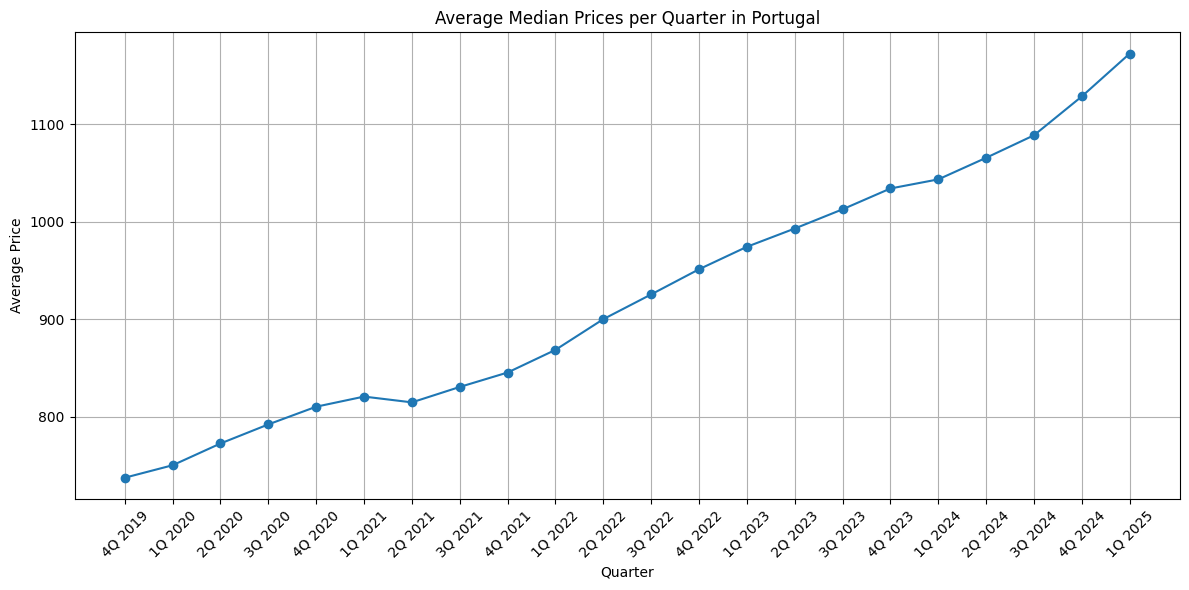

In [159]:
plt.figure(figsize=(12, 6))
house_df[quarter_headers].mean().iloc[::-1].plot(kind='line', marker="o")
ticks = range(len(quarter_headers))

plt.title('Average Median Prices per Quarter in Portugal')
plt.xlabel('Quarter')
plt.ylabel('Average Price')
plt.xticks(ticks=ticks, labels=quarter_headers[::-1], rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

We clearly see the time trend. It implies the addition of the time feature for the modeling.

In [160]:
region_avg_prices = house_df.mean(axis=1)
most_expensive_region = region_avg_prices.idxmax()
cheapest_region = region_avg_prices.idxmin()

In [161]:
region_avg_prices.nlargest(5)

Designation
Lisboa     3786.409091
Cascais    3352.681818
Oeiras     2844.227273
Loulé      2803.045455
Lagos      2654.500000
dtype: float64

In [162]:
region_avg_prices.nsmallest(5)

Designation
Figueira de Castelo Rodrigo    183.318182
Penamacor                      261.409091
Mêda                           272.409091
Mação                          276.545455
Almeida                        284.636364
dtype: float64

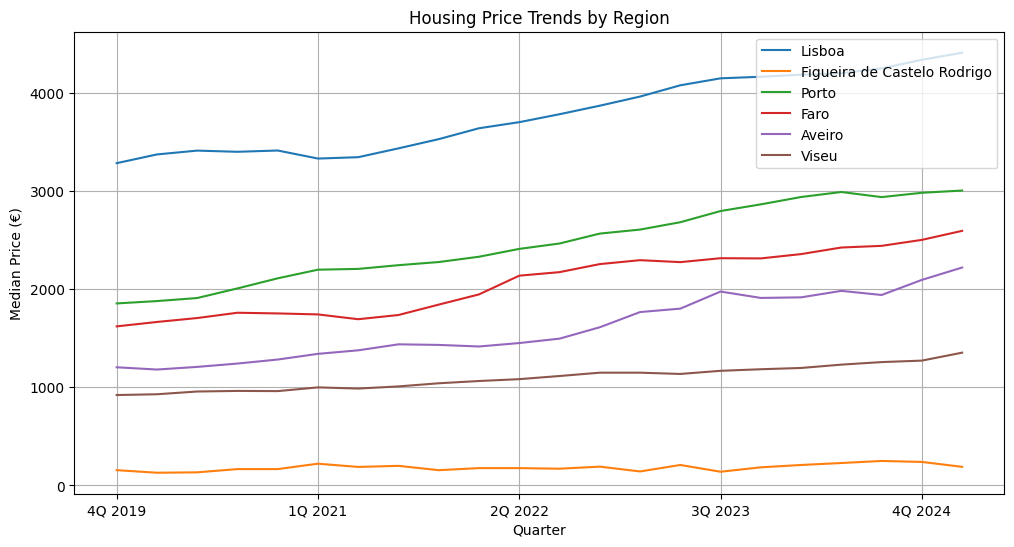

In [163]:
regions_to_plot = [most_expensive_region, cheapest_region, 'Porto', 'Faro', 'Aveiro', 'Viseu']  # or any subset
plt.figure(figsize=(12, 6))

for region in regions_to_plot:
    house_df.loc[region][::-1].plot()

plt.legend()
plt.title("Housing Price Trends by Region")
plt.xlabel("Quarter")
plt.ylabel("Median Price (€)")
plt.grid(True)
plt.show()

In [164]:
house_reset = house_df.reset_index()
df_long = house_reset.melt(
    id_vars=['Designation'],
    var_name='Time_Period',
    value_name='Price'
)
df_long.head()
descriptive_stats = df_long.groupby('Designation')['Price'].describe().round(2)
print(descriptive_stats.to_string())

                             count     mean     std      min      25%      50%      75%      max
Designation                                                                                     
Abrantes                      22.0   562.27   77.86   475.00   503.25   538.50   620.75   760.00
Aguiar da Beira               22.0   509.42  224.77   253.00   313.75   414.00   767.21   830.73
Alandroal                     22.0   498.91  122.80   281.00   444.00   500.50   535.50   714.00
Albergaria-a-Velha            22.0   935.77  145.02   752.00   811.00   880.00  1072.50  1194.00
Albufeira                     22.0  2425.64  365.22  1956.00  2065.25  2397.00  2760.50  3040.00
Alcanena                      22.0   504.32   82.32   443.00   460.00   479.50   499.50   789.00
Alcobaça                      22.0  1077.27  185.72   826.00   897.75  1065.00  1256.50  1428.00
Alcochete                     22.0  1831.27  267.81  1393.00  1559.00  1888.00  2062.00  2209.00
Alcoutim                      

In [ ]:
descriptive_stats.to_csv(os.path.join(PDATA_DIR, 'house_n4_descriptive_stats_by_designation.csv'))

### Income

In [245]:
income_raw_df = pd.read_csv(INCOME_FILE, encoding="utf-8")
income_raw_df.head()

,01. Ano,02. Nome Região (Portugal),03. Âmbito Geográfico,04. Filtro 1,05. Filtro 2,06. Filtro 3,08. Símbolo,07. Escala,09. Valor
0,2013.0,Portugal,NaN,01. Inferior ao 1.º ciclo,NaN,NaN,x,euros,NaN
1,2013.0,Portugal,NaN,02. Básico - 1º Ciclo,NaN,NaN,x,euros,NaN
2,2013.0,Portugal,NaN,03. Básico - 2º Ciclo,NaN,NaN,x,euros,NaN
3,2013.0,Portugal,NaN,04. Básico - 3º Ciclo,NaN,NaN,x,euros,NaN
4,2013.0,Portugal,NaN,05. Secundário,NaN,NaN,x,euros,NaN


#### Preprocessing

In [247]:
{i: "" for i in  income_raw_df.columns}

{'01. Ano': '',
 '02. Nome Região (Portugal)': '',
 '03. Âmbito Geográfico': '',
 '04. Filtro 1': '',
 '05. Filtro 2': '',
 '06. Filtro 3': '',
 '08. Símbolo': '',
 '07. Escala': '',
 '09. Valor': ''}

In [248]:
income_columns = {
    '01. Ano': 'year',
    '02. Nome Região (Portugal)': 'region',
    '03. Âmbito Geográfico': 'scope',
    '04. Filtro 1': 'education_level',
    '08. Símbolo': 'symbol',
    '07. Escala': 'unit',
    '09. Valor': 'value'
 }

In [336]:
income_df = income_raw_df.drop(columns=["05. Filtro 2", "06. Filtro 3"]).rename(columns=income_columns)
income_df = income_df.dropna(subset=["value", "year", "scope", "education_level"])
income_df["year"] = income_df["year"].astype(int)
income_df = income_df[income_df["scope"] == "Município"]
income_df = income_df[income_df["year"] >= 2019]
income_df

,year,region,scope,education_level,symbol,unit,value
20449,2019,Abrantes,Município,01. Inferior ao 1.º ciclo,NaN,euros,750.4
20450,2019,Abrantes,Município,02. Básico - 1º Ciclo,NaN,euros,939.7
20451,2019,Abrantes,Município,03. Básico - 2º Ciclo,NaN,euros,928.5
20452,2019,Abrantes,Município,04. Básico - 3º Ciclo,NaN,euros,933.5
20453,2019,Abrantes,Município,05. Secundário,NaN,euros,1027.3
...,...,...,...,...,...,...,...
37382,2023,Vouzela,Município,05. Secundário,NaN,euros,1082.9
37384,2023,Vouzela,Município,07. Bacharelato,NaN,euros,1357.6
37385,2023,Vouzela,Município,08. Licenciatura,NaN,euros,1562.9
37386,2023,Vouzela,Município,09. Mestrado,NaN,euros,1611.7


In [337]:
total_income_df = income_df[income_df['education_level'] == 'Total'].copy()
total_income_file = os.path.join(PDATA_DIR, 'total_average_income_by_municipality.csv')
total_income_df.to_csv(total_income_file, index=False)

total_income_df.head()

,year,region,scope,education_level,symbol,unit,value
20459,2019,Abrantes,Município,Total,NaN,euros,1109.4
20470,2019,Águeda,Município,Total,NaN,euros,1071.4
20481,2019,Aguiar da Beira,Município,Total,NaN,euros,818.6
20492,2019,Alandroal,Município,Total,NaN,euros,904.2
20503,2019,Albergaria-a-Velha,Município,Total,NaN,euros,1126.7


In [338]:
education_income_df = income_df[income_df['education_level'] != 'Total'].copy()
avg_income_file = os.path.join(PDATA_DIR, 'average_income_by_education.csv')
education_income_df.to_csv(avg_income_file, index=False)

education_income_df.head()

,year,region,scope,education_level,symbol,unit,value
20449,2019,Abrantes,Município,01. Inferior ao 1.º ciclo,NaN,euros,750.4
20450,2019,Abrantes,Município,02. Básico - 1º Ciclo,NaN,euros,939.7
20451,2019,Abrantes,Município,03. Básico - 2º Ciclo,NaN,euros,928.5
20452,2019,Abrantes,Município,04. Básico - 3º Ciclo,NaN,euros,933.5
20453,2019,Abrantes,Município,05. Secundário,NaN,euros,1027.3


#### Descriptive statistics

In [339]:
income_avg_df = education_income_df.groupby('region')['value'].mean().reset_index()

print("\n--- Top 10 Consistently Highest-Income Municipalities (Avg. 2019-2023) ---")
top_10_consistent = income_avg_df.sort_values('value', ascending=False).head(10)
print(top_10_consistent)

print("\n--- Bottom 10 Consistently Lowest-Income Municipalities (Avg. 2019-2023) ---")
bottom_10_consistent = income_avg_df.sort_values('value', ascending=True).head(10)
print(bottom_10_consistent)


--- Top 10 Consistently Highest-Income Municipalities (Avg. 2019-2023) ---
            region        value
298  Vila do Porto  2541.045946
70    Castro Verde  2317.856098
243          Sines  2280.204167
7        Alcochete  2065.422727
171         Oeiras  1853.958000
181        Palmela  1766.258000
207    Porto Santo  1727.533333
121         Lisboa  1709.666000
265          Trofa  1660.434000
23         Amadora  1630.580000

--- Bottom 10 Consistently Lowest-Income Municipalities (Avg. 2019-2023) ---
                  region       value
191             Penedono  900.124000
236          Sernancelhe  934.200000
82                 Crato  948.732143
233              Sardoal  952.027586
52   Cabeceiras de Basto  955.117949
299              Vimioso  956.878378
198         Ponta do Sol  957.800000
215              Resende  963.620000
206          Porto Moniz  964.160000
277      Vieira do Minho  971.351282


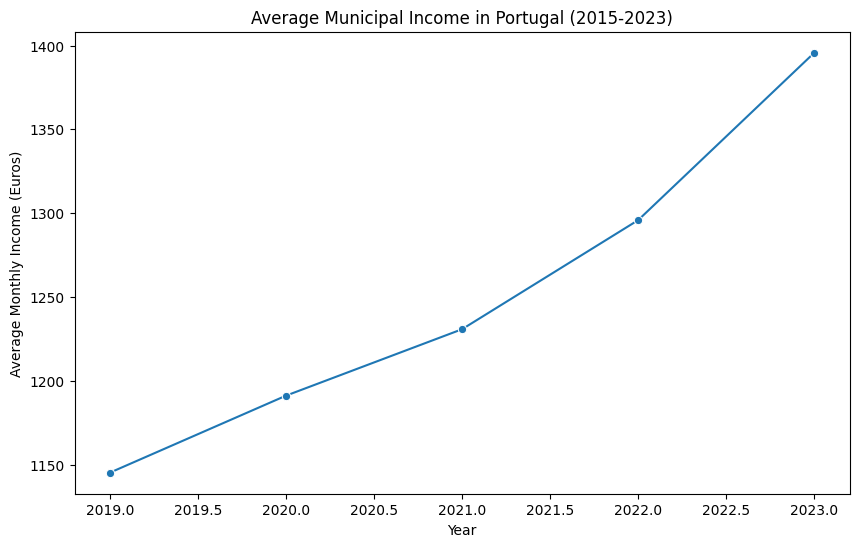

In [273]:
# We group by 'Year' and get the mean of ALL municipalities for that year.
df_avg_by_year = education_income_df.groupby('year')['value'].mean().reset_index()

# Plot 2: Line Chart (Evolution)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg_by_year, x='year', y='value', marker='o')

plt.title('Average Municipal Income in Portugal (2015-2023)')
plt.xlabel('Year')
plt.ylabel('Average Monthly Income (Euros)')
plt.show()

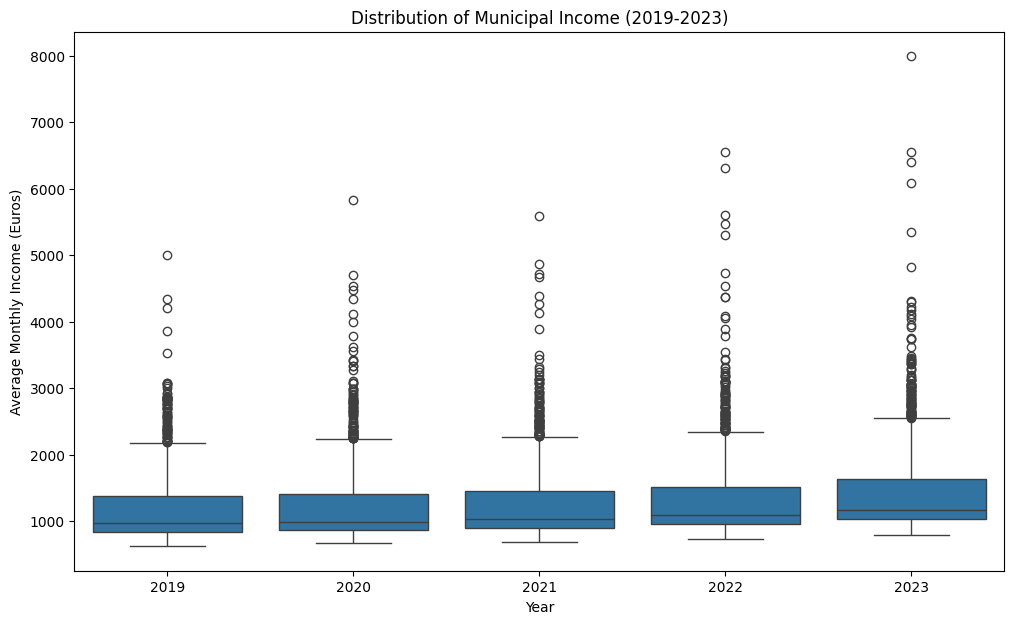

In [275]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=education_income_df, x='year', y='value')

plt.title('Distribution of Municipal Income (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Average Monthly Income (Euros)')
plt.show()

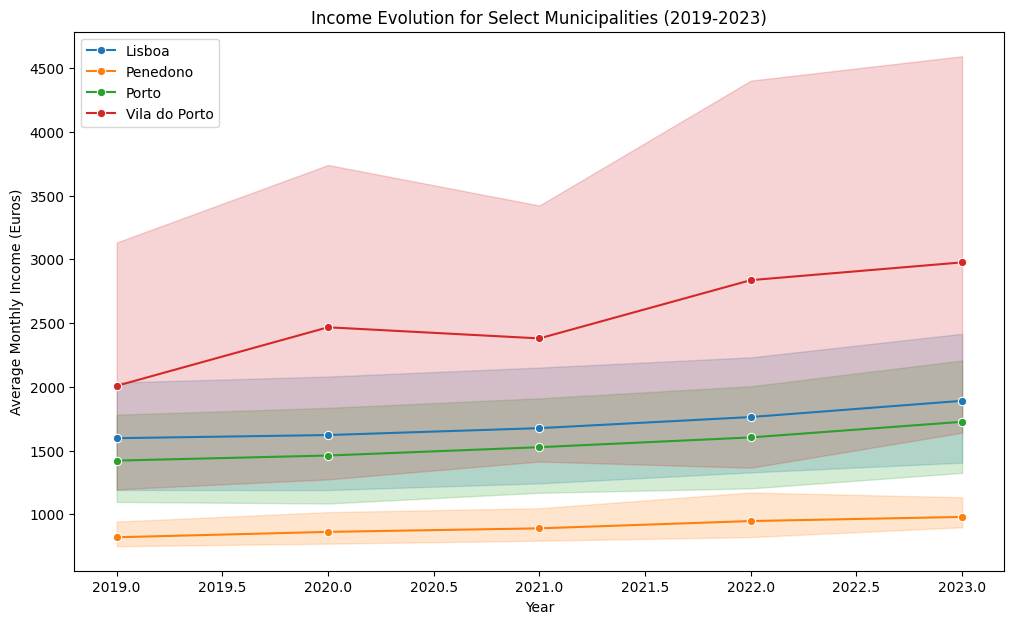

In [277]:
richest_name = top_10_consistent['region'].iloc[0]
poorest_name = bottom_10_consistent['region'].iloc[0]

# We'll plot Lisboa, Porto, and the #1 most/least wealthy from our consistent list
mun_to_compare = ['Lisboa', 'Porto', richest_name, poorest_name]
df_compare = education_income_df[education_income_df['region'].isin(mun_to_compare)]

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_compare, x='year', y='value', hue='region', marker='o')

plt.title(f"Income Evolution for Select Municipalities (2019-2023)")
plt.xlabel('Year')
plt.ylabel('Average Monthly Income (Euros)')
plt.legend()
plt.show()

### Weather

In [320]:
weather_daily_df = pd.read_csv(WEATHER_FILE, index_col=0)
weather_daily_df["date"] = pd.to_datetime(weather_daily_df["date"])
weather_daily_df = weather_daily_df[weather_daily_df["date"] >= "2019-10-01"]
weather_daily_df["quarter_year"] = weather_daily_df["date"].dt.to_period("Q").astype(str).str.replace(r'(\d{4})Q(\d)', r"\2Q \1", regex=True)
weather_daily_df = weather_daily_df.rename(columns={'region': 'municipality'})

#### Feature engineering

Convert sunshine duration to hours (originally in seconds).

In [321]:
weather_daily_df["sunshine_duration_h"] = weather_daily_df["sunshine_duration_s"] / 3600
weather_daily_df = weather_daily_df.drop(columns=["sunshine_duration_s"])
weather_daily_df.head()

,municipality,date,temp_max_c,temp_min_c,windspeed_mean_kmh,precipitation_sum_mm,quarter_year,sunshine_duration_h
273,Arcos de Valdevez,2019-10-01,21.6,15.7,7.4,6.1,4Q 2019,9.589503
274,Arcos de Valdevez,2019-10-02,20.3,13.2,7.7,0.0,4Q 2019,10.791772
275,Arcos de Valdevez,2019-10-03,22.4,12.1,4.6,1.3,4Q 2019,8.929275
276,Arcos de Valdevez,2019-10-04,21.1,13.1,5.7,1.0,4Q 2019,5.726456
277,Arcos de Valdevez,2019-10-05,20.3,12.1,6.1,0.0,4Q 2019,7.976439


In [322]:
# Helper columns
weather_daily_df["is_rainy"] = weather_daily_df["precipitation_sum_mm"] > 0
weather_daily_df["is_sunny"] = weather_daily_df["sunshine_duration_h"] >= 8
weather_daily_df["is_windy"] = weather_daily_df["windspeed_mean_kmh"] > 30.0
weather_daily_df["no_rain"] = weather_daily_df["precipitation_sum_mm"] == 0
weather_daily_df["is_temp_ok"] = (weather_daily_df["temp_min_c"] >= 17) & (weather_daily_df["temp_max_c"] <= 28)
weather_daily_df["temp_mean_c"] = (weather_daily_df["temp_max_c"] + weather_daily_df["temp_min_c"]) / 2

In [325]:
weather_quarter_df = weather_daily_df.groupby(by=["municipality", "quarter_year"]).agg(
    # aggregate for the quarter values
    total_sunshine_h=pd.NamedAgg(column="sunshine_duration_h", aggfunc="sum"),
    mean_sunshine_h=pd.NamedAgg(column="sunshine_duration_h", aggfunc="mean"),
    windspeed_mean_kmh=pd.NamedAgg(column="windspeed_mean_kmh", aggfunc="mean"),
    total_precipitation_mm=pd.NamedAgg(column="precipitation_sum_mm", aggfunc="sum"),
    mean_precipitation_mm=pd.NamedAgg(column="precipitation_sum_mm", aggfunc="mean"),

    # features
    windy_days=pd.NamedAgg(column="is_windy", aggfunc="sum"),
    rainy_days=pd.NamedAgg(column="is_rainy", aggfunc="sum"),
    sunny_days=pd.NamedAgg(column="is_sunny", aggfunc="sum"),
    warm_days=pd.NamedAgg(column="is_temp_ok", aggfunc="sum")
).reset_index()
weather_quarter_df[weather_quarter_df["municipality"] == "Aveiro"]
# weather_quarter_df

,municipality,quarter_year,total_sunshine_h,mean_sunshine_h,windspeed_mean_kmh,total_precipitation_mm,mean_precipitation_mm,windy_days,rainy_days,sunny_days,warm_days
814,Aveiro,1Q 2020,694.762311,7.634751,12.800000,234.2,2.573626,0,46,60,0
815,Aveiro,1Q 2021,678.421267,7.538014,13.444444,342.1,3.801111,2,45,56,0
816,Aveiro,1Q 2022,720.760794,8.008453,11.788889,170.5,1.894444,0,28,67,0
817,Aveiro,1Q 2023,725.641950,8.062688,12.898889,273.0,3.033333,2,42,66,0
818,Aveiro,1Q 2024,649.753275,7.140146,14.617582,591.3,6.497802,4,54,48,0
819,Aveiro,1Q 2025,628.320958,6.981344,13.076667,674.8,7.497778,2,59,46,0
820,Aveiro,2Q 2020,1032.213533,11.343006,13.409890,258.4,2.839560,0,49,79,5
821,Aveiro,2Q 2021,1058.906956,11.636340,13.431868,204.6,2.248352,0,45,80,2
822,Aveiro,2Q 2022,1056.350025,11.608242,14.840659,204.8,2.250549,2,47,81,7
823,Aveiro,2Q 2023,1059.420886,11.641988,13.843956,193.0,2.120879,3,39,85,12


In [326]:
weather_quarter_df.to_csv(WEATHER_QUARTER_FILE, index=False)

#### Bivariate analysis (Weather & House prices)

In [243]:
pass

### Services

### Combined

Since we have income data only until 2023 year we'll cut the data to that extent.

In [327]:
df_house = pd.read_csv(HOUSE_CLEAN_FILE)
df_weather = pd.read_csv(WEATHER_QUARTER_FILE)
df_income = pd.read_csv(INCOME_CLEAN_FILE)
df_services = pd.read_csv(SERVICES_FILE)

In [340]:
melted_cols = [col for col in df_house.columns if col != 'Designation']
df_house_melted = df_house.melt(
    id_vars=['Designation'],
    value_vars=melted_cols,
    var_name='quarter_year',
    value_name='house_price'
).rename(columns={'Designation': 'municipality'})

df_merged_quarterly = pd.merge(
    df_house_melted,
    df_weather,
    on=['municipality', 'quarter_year'],
    how='inner'
)

df_income_clean = df_income[['year', 'region', 'value']].rename(
    columns={'region': 'municipality', 'value': 'avg_income'}
)
df_income_clean['municipality'] = df_income_clean['municipality'].str.replace(r'\s*\[.*\]', '', regex=True).str.strip()
df_services_clean = df_services.rename(
    columns={'area': 'municipality'}
)
df_merged_quarterly['year'] = df_merged_quarterly['quarter_year'].str.split(' ').str[-1].astype(int)

In [315]:

df_merged_with_income = pd.merge(
    df_merged_quarterly,
    df_income_clean,
    on=['municipality', 'year'],
    how='left'
)

df_final = pd.merge(
    df_merged_with_income,
    df_services_clean,
    on='municipality',
    how='left'
)

df_final

,municipality,quarter_year,house_price,total_sunshine_h,mean_sunshine_h,windspeed_mean_kmh,total_precipitation_mm,mean_precipitation_mm,windy_days,rainy_days,...,library,mall,museum,pharmacy,police,post_office,school,station,theatre,university
0,Arcos de Valdevez,1Q 2025,960.000000,562.854075,6.253934,9.480000,889.9,9.887778,0,61,...,4.0,2.0,5.0,10.0,2.0,4.0,15.0,1.0,1.0,0.0
1,Caminha,1Q 2025,1461.000000,580.537433,6.450416,12.465556,752.8,8.364444,1,63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Melgaço,1Q 2025,475.000000,559.822186,6.220247,8.952222,687.6,7.640000,0,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Monção,1Q 2025,1244.000000,704.687597,7.829862,6.223333,1374.3,15.270000,0,90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Paredes de Coura,1Q 2025,770.000000,555.353503,6.170594,10.261111,753.9,8.376667,0,61,...,1.0,0.0,1.0,4.0,1.0,1.0,7.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6685,Porto Santo,4Q 2019,1055.000000,809.273997,8.796456,22.133696,70.3,0.764130,16,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6686,Ribeira Brava,4Q 2019,625.000000,800.039878,8.696086,9.264130,139.7,1.518478,0,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6687,Santa Cruz,4Q 2019,1130.000000,859.389375,9.341189,7.531522,131.7,1.431522,0,49,...,4.0,13.0,4.0,12.0,6.0,6.0,24.0,4.0,3.0,0.0
6688,Santana,4Q 2019,844.000000,1020.573564,11.093191,7.280435,176.7,1.920652,0,35,...,1.0,0.0,3.0,4.0,1.0,4.0,10.0,2.0,3.0,0.0


In [ ]:
df_final